In [1]:
using Distributions
using Ipopt
using Gadfly
using DataFrames
include("../src/SVDD.jl");

Generate some test data:

In [2]:
solver = IpoptSolver(print_level=0)
srand(42);

In [3]:
n = 100
d1 = [[o, (5.5(o-0.5)^2 + rand() * 0.3) + 0.5] for o in rand(Truncated(Normal(), 0.2, 0.8), n)]
d2 = [[o, -(5.5(o-0.5)^2 + rand() * 0.3) + 0.5] for o in rand(Truncated(Normal(), 0.2, 0.8), n)]
d3 = [reshape(rand(70), 2, 35)]
dummy_data = hcat(d1..., d2..., d3...)
labels = fill(:U, size(dummy_data,2));

Define plotting function:

In [4]:
function plot(model)
    df = DataFrame(model.data')
    distances = SVDD.predict(model, model.data)
    df[:color] = max.(distances, 0.0)
    min_x, max_x = extrema(model.data[1,:])
    range_x = max_x - min_x
    min_y, max_y = extrema(model.data[2,:])
    range_y = max_y - min_y
    axis_scale = 1.0

    dist_min, dist_max = extrema(distances)
    contour_min = dist_min
    contour_max = dist_max
    number_steps = 5
    contour_step = (contour_max - contour_min) / number_steps

    Gadfly.plot(layer(df, x=:x1, y=:x2, color=:color, Geom.point),
                layer(z = (z1, z2) ->  max(SVDD.predict(model, [z1 z2]')[1], 0.0),
                    x = linspace(min_x - range_x * axis_scale, max_x + range_x * axis_scale, 100),
                    y = linspace(min_y - range_y * axis_scale, max_y + range_y * axis_scale, 100),
                Geom.contour()),
    Guide.colorkey(title="f(x)"))
end;

# Vanilla SVDD

In [5]:
model = SVDD.VanillaSVDD(dummy_data)
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(15)), SVDD.FixedCStrategy(0.01))
SVDD.initialize!(model, init_strategy)
SVDD.fit!(model, solver);

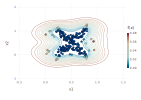


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



In [6]:
plot(model)

# SVDDNeg

Set the learning pools:

In [7]:
pools = copy(labels)
pools[1:n] = :Lout;

In [8]:
model = SVDD.SVDDneg(dummy_data, pools)
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(15)), SVDD.FixedCStrategy(0.01))
SVDD.initialize!(model, init_strategy)
SVDD.set_adjust_K!(model, true)
SVDD.fit!(model, solver);

[info | SVDD]: Adjusting Kernel Matrix.


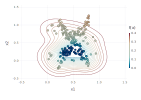

[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 7.993605777301127e-15. The sum of adjustments is 4.1703463719161963e-11


In [9]:
plot(model)

# SSAD

In [10]:
pools = copy(labels)
pools[dummy_data[2,:] .> .8] = :Lin
pools[2n+1:end] = :Lout;

In [11]:
model = SVDD.SSAD(dummy_data, pools)
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(15)), SVDD.FixedCStrategy(0.01))
SVDD.set_kappa!(model, 0.5)
SVDD.initialize!(model, init_strategy)
SVDD.set_adjust_K!(model, true)
SVDD.fit!(model, solver);

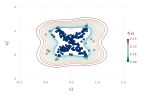

[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 7.993605777301127e-15. The sum of adjustments is 4.1703463719161963e-11


In [12]:
plot(model)

In [13]:
pools[dummy_data[2,:] .< 0.1] = :Lout

SVDD.set_pools!(model, pools)
SVDD.fit!(model, solver);

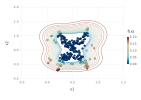

In [15]:
plot(model)